This kernel uses the following kernel code:
* https://www.kaggle.com/h4211819/image-size-eda
* https://www.kaggle.com/yangsaewon/basic-eda-train-test-image-distribution-check
* https://www.kaggle.com/kaerunantoka/extract-image-features

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import os
import pickle
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
print(os.listdir('../input'))
print(os.listdir('../input/diabetic-retinopathy-detection-image-size'))

['aptos2019-blindness-detection', 'diabetic-retinopathy-detection-image-size']
['pre_train_shape.csv', 'pre_test_shape.csv']


# 1. present competition

In [3]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [4]:
len(train), len(test)

(3662, 1928)

In [5]:
#the func is from https://www.kaggle.com/toshik/image-size-and-rate-of-new-whale
def get_size_list(targets, dir_target):
    result = list()
    for target in tqdm(targets):
        img = np.array(Image.open(os.path.join(dir_target, target+'.png')))
        result.append(img.shape)
    return result

# the func is from https://www.kaggle.com/kaerunantoka/extract-image-features
def get_size(file_name_list, dir_target):
    result = list()
    #filename = images_path + filename
    for file_name in tqdm(file_name_list):
        st = os.stat(f'{dir_target}/{file_name}.png')
        result.append(st.st_size)
    return result

In [6]:
train['image_shape'] = get_size_list(train.id_code.tolist(),
                                     dir_target='../input/aptos2019-blindness-detection/train_images')
test['image_shape'] = get_size_list(test.id_code.tolist(),
                                    dir_target='../input/aptos2019-blindness-detection/test_images')
train['image_size'] = get_size(train.id_code.tolist(),
                               dir_target='../input/aptos2019-blindness-detection/train_images')
test['image_size'] = get_size(test.id_code.tolist(),
                              dir_target='../input/aptos2019-blindness-detection/test_images')

In [7]:
for df in [train, test]:
    df['height'] = df['image_shape'].apply(lambda x:x[0])
    df['width'] = df['image_shape'].apply(lambda x:x[1])
    df['width_height_ratio'] = df['height'] / df['width']
    df['width_height_added'] = df['height'] + df['width']

In [8]:
train.head()

,id_code,diagnosis,image_shape,image_size,height,width,width_height_ratio,width_height_added
0,000c1434d8d7,2,"(2136, 3216, 3)",3218676,2136,3216,0.664179,5352
1,001639a390f0,4,"(2136, 3216, 3)",2261129,2136,3216,0.664179,5352
2,0024cdab0c1e,1,"(1736, 2416, 3)",1882172,1736,2416,0.718543,4152
3,002c21358ce6,0,"(1050, 1050, 3)",975218,1050,1050,1.000000,2100
4,005b95c28852,0,"(1536, 2048, 3)",1819430,1536,2048,0.750000,3584


In [9]:
train.describe()

,diagnosis,image_size,height,width,width_height_ratio,width_height_added
count,3662.000000,3.662000e+03,3662.000000,3662.000000,3662.000000,3662.000000
mean,1.126980,2.349280e+06,1526.830147,2015.176679,0.796761,3542.006827
std,1.298409,1.762452e+06,542.663120,884.301940,0.126391,1419.133265
min,0.000000,2.217370e+05,358.000000,474.000000,0.664179,832.000000
25%,0.000000,1.003996e+06,1050.000000,1050.000000,0.718543,2100.000000
50%,1.000000,1.934951e+06,1536.000000,2144.000000,0.750000,3584.000000
75%,2.000000,2.846848e+06,1958.000000,2588.000000,1.000000,4546.000000
max,4.000000,7.674292e+06,2848.000000,4288.000000,1.000000,7136.000000


In [10]:
test.describe()

,image_size,height,width,width_height_ratio,width_height_added
count,1.928000e+03,1928.000000,1928.000000,1928.000000,1928.000000
mean,8.370050e+05,783.152490,1043.535788,0.755328,1826.688278
std,1.291580e+06,541.308109,740.511732,0.048644,1280.116549
min,1.827340e+05,480.000000,640.000000,0.671271,1120.000000
25%,2.192625e+05,480.000000,640.000000,0.750000,1120.000000
50%,2.297655e+05,480.000000,640.000000,0.750000,1120.000000
75%,4.286760e+05,614.000000,819.000000,0.750000,1433.000000
max,5.810538e+06,1958.000000,2896.000000,1.000000,4840.000000


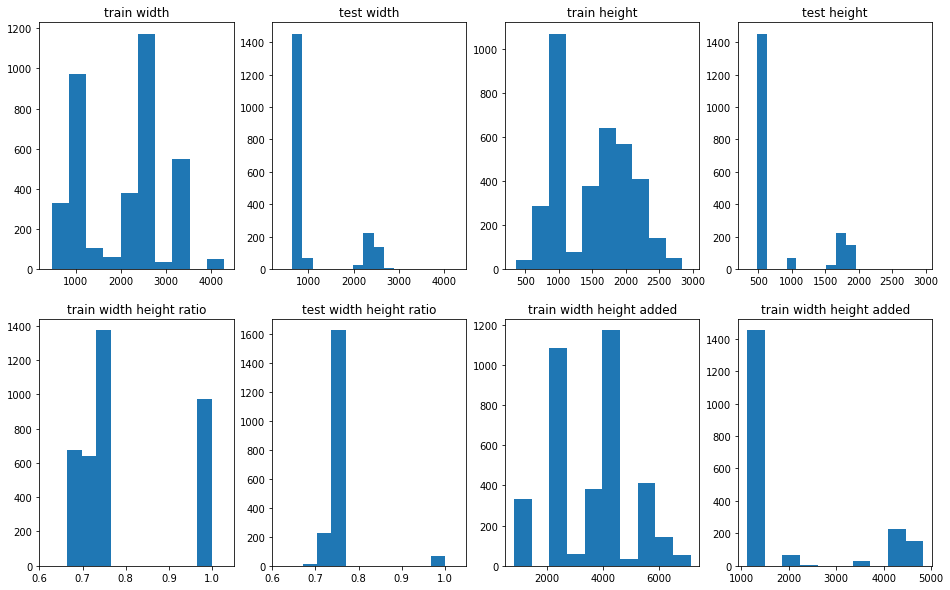

In [11]:
fig = plt.figure(figsize=(16,10))
plt.subplot(241)
plt.hist(train['width'])
plt.title("train width")
plt.xlim(200, 4500)

plt.subplot(242)
plt.hist(test['width'])
plt.title("test width")
plt.xlim(200, 4500)

plt.subplot(243)
plt.hist(train['height'])
plt.title("train height")
plt.xlim(200, 3100)

plt.subplot(244)
plt.hist(test['height'])
plt.title("test height")
plt.xlim(200, 3100)

plt.subplot(245)
plt.hist(train['width_height_ratio'])
plt.title("train width height ratio")
plt.xlim(0.6, 1.05)


plt.subplot(246)
plt.hist(test['width_height_ratio'])
plt.title("test width height ratio")
plt.xlim(0.6, 1.05)

plt.subplot(247)
plt.hist(train['width_height_added'])
plt.title("train width height added")

plt.subplot(248)
plt.hist(test['width_height_added'])
plt.title("train width height added");

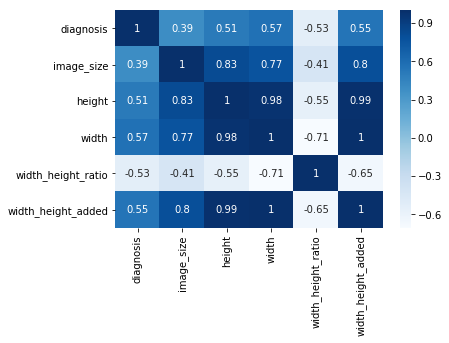

In [12]:
sns.heatmap(train.corr(), cmap=plt.cm.Blues, annot=True);

* Many feature seems to be correlated with the target.

In [13]:
train_meta = train.groupby(['width', 'height', 'diagnosis']).agg({'diagnosis':'count'}).unstack('diagnosis').fillna(0)
train_meta.columns = [f'{i[0]}_{i[1]}' for i in train_meta.columns]
train_meta['train_count'] = train_meta.sum(axis=1)

test_meta = test.groupby(['width', 'height']).agg({'id_code':'count'}).rename(columns={'id_code':'pub_test_count'})
count_ratio = train_meta.join(test_meta, how='outer')

for i in range(5):
    count_ratio.loc[:, f'{i}_ratio'] = count_ratio.iloc[:, i] / count_ratio['train_count']

count_ratio = count_ratio.fillna(0)

count_ratio = count_ratio.astype({'diagnosis_0': int, 'diagnosis_1': int, 'diagnosis_2': int,
                                  'diagnosis_3': int, 'diagnosis_4': int})
count_ratio = count_ratio.astype({'train_count': int, 'pub_test_count': int})

count_ratio.reset_index(inplace=True)
count_ratio.set_index(['width', 'height', 'train_count', 'pub_test_count'], inplace=True)

In [14]:
count_ratio

,,,,diagnosis_0,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4,0_ratio,1_ratio,2_ratio,3_ratio,4_ratio
width,height,train_count,pub_test_count,,,,,,,,,,
474,358,2,0,0,0,1,0,1,0.000000,0.000000,0.500000,0.000000,0.500000
640,480,42,1403,0,0,33,5,4,0.000000,0.000000,0.785714,0.119048,0.095238
768,576,0,2,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
819,614,287,45,279,7,1,0,0,0.972125,0.024390,0.003484,0.000000,0.000000
1050,1050,974,69,901,19,39,2,13,0.925051,0.019507,0.040041,0.002053,0.013347
1467,1110,2,2,0,0,2,0,0,0.000000,0.000000,1.000000,0.000000,0.000000
1476,1117,14,2,10,0,0,2,2,0.714286,0.000000,0.000000,0.142857,0.142857
1504,1000,92,0,0,2,63,9,18,0.000000,0.021739,0.684783,0.097826,0.195652
1844,1226,61,0,0,13,28,1,19,0.000000,0.213115,0.459016,0.016393,0.311475


* Training data has different target distribution for each image shape.
  * For example 1050x1050 is high ratio of class_0, 2136x3216 is high ratio of class_2
* If we leave the image shape information in the preprocessed image, there is a possibility of overfitting, so be very careful.
* Let's look at the images.

# 2.Display an image for each shape

In [15]:
def im_show(height, width, num):
    tmp = train[(train['width'] == width) & (train['height'] == height)].id_code
    dir_target = '../input/aptos2019-blindness-detection/train_images'
    id = tmp.values[num]
    img = Image.open(os.path.join(dir_target, id +'.png'))
    plt.imshow(img.resize((256, 256)))
    plt.tick_params(bottom=False,
                    left=False,
                    right=False,
                    top=False,
                    labelbottom=False,
                    labelleft=False,
                    labelright=False,
                    labeltop=False)
    value = train.loc[train['id_code'] == id, :].values[0]
    plt.title(f'({value[4]},{value[5]})->(256,256)\n {id}, diagnosis:{value[1]}')

def five_img_plot(height, width):
    print('-' * 10)
    print(f'shape({height}, {width})')
    plt.figure(figsize=(16, 4))
    for i in range(5):
        plt.subplot(1,5,i+1)
        im_show(height, width, i)
    plt.show()

----------
shape(480, 640)


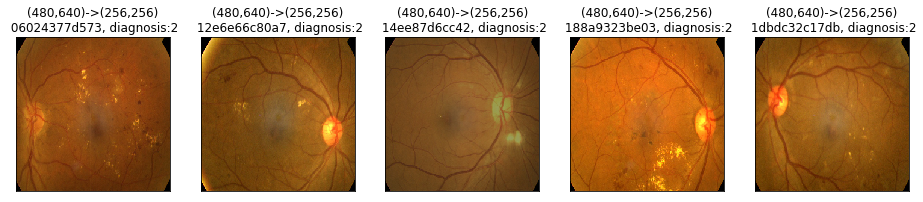

----------
shape(614, 819)


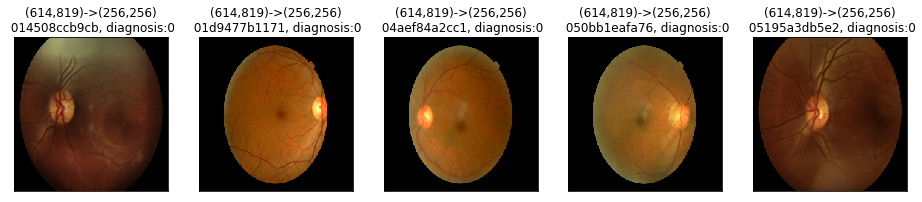

----------
shape(1050, 1050)


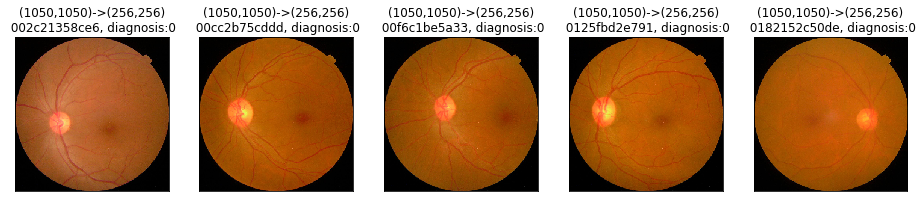

----------
shape(1536, 2048)


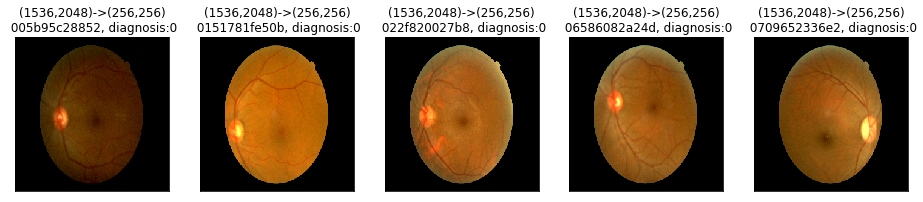

----------
shape(1736, 2416)


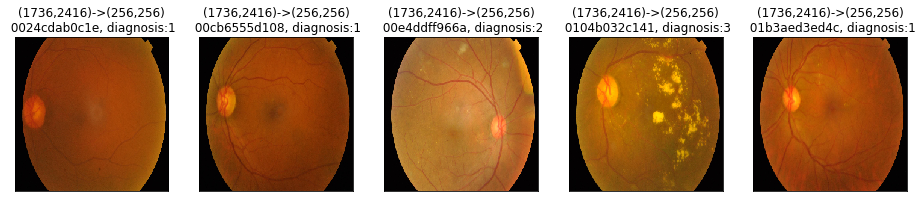

----------
shape(1958, 2588)


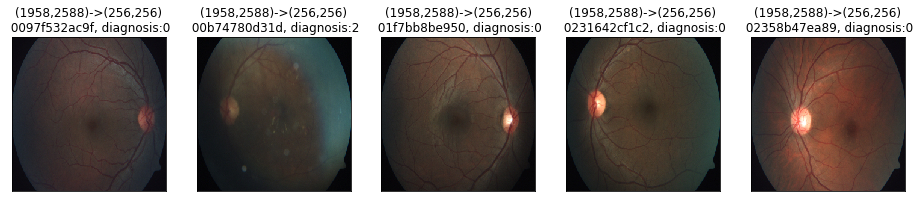

----------
shape(2588, 3388)


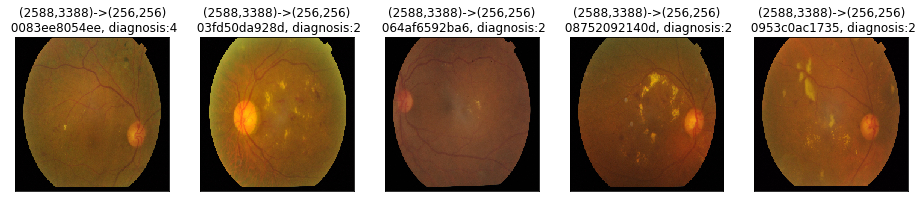

In [16]:
five_img_plot(480, 640)
five_img_plot(614, 819)
five_img_plot(1050, 1050)
five_img_plot(1536, 2048)
five_img_plot(1736, 2416)
five_img_plot(1958, 2588)
five_img_plot(2588, 3388)